#  Homework 04: KNN for Churn Prediction

## Introduction

This week, we will go more deeply into the churn prediction task introduced in the previous homework. As you already know, churn prediction is one of the most popular use cases of machine learning in business, consisting of detecting customers who are likely to cancel a subscription to a service. Churn can be triggered by better price offers, more interesting packages, bad service experiences or personal situation changes experienced by customers. To timely prevent customers' churn, companies might adopt a machine learning classifier able to predict churn on an individual customer basis, and then use the predictions of this classifier to know when countermeasures (e.g., discounts or special offers) against churn are needed, to prevent the churn event.  

In the previous homework, you were expected to use a range of demographic and basic contract-related features and create five additional behavioral as well as an appropriate evaluation method and performance metric(s) to assess the goodness of your classifier in predicting churn for customers.

In this homework, we ask you again to work on the machine-learning pipeline presented at the end of lecture 4, by instantiating, exploring, and fine-tuning a series of k-Nearest-Neighbors (kNNs) classifiers. Specifically, we will ask you to:

- Experiment with distance matrices and KNN classifiers fed with only demographic features or only behavioral features.
- Experiment with distance matrices and KNN classifiers fed with both demographic and behavioral features. 
- Report, visually, the performance of three fine-tuned KNN classifiers (demographic, tuned), (behavioral, tuned), and (combined, tuned), and discuss.

The focus of this homework is on modelling and not on the quality of features. Therefore, note that there should be **no** need to perform any feature engineering in this homework. You are expected to re-use the features (and possibly a part of the source code) that you have created in homework 3. If you have not submitted homework 3, please do get in touch with the TAs, and they will provide five example behavioral feature to use in this homework.  


## Submission 

The homework is due **Mar 30, 2021 23:59 CET**. The notebook must be pushed to your GitHub classroom repository. 

If you have any questions, feel free to use the Q&A forum in Moodle. 

## Some Instructions 

1. You are allowed to use any built-in Python library. If you want to use an external library, you have to justify it. 
2. Make sure you use the data folder provided in the repository in **read-only** mode. 
3. Please write all your comments in English, and use meaningful variable names in your code. 
4. Your repo should have a single notebook (plus the required data files) in the master branch. 
5. Be sure to hand in a fully-run and evaluated notebook (check the rendered notebook on the GitHub website once you have pushed). 
6. Be sure to provide a textual description of your thoughts, assumptions, solutions, and explanations for your answers, when requested.

## The Data Set

In this homework, you will use the same data set as in homework 3. The `data` folder includes CSV files pertaining to customer's demographic attributes, contract information, and monthly service-related data. 

For the sake of easiness and clarity, in this homework, we will use the convention that:
- features you compute from the **customer.csv** file are referred to as **(pseudo)demographic / demographic features**;
- features you compute from the **phone_usage.csv**, **services.csv**, and **charges.csv** files are referred to as **behavioral features**.

The **target values** are represented by the **churn labels** listed in the **churn.csv** file under the **"Churn" column**.   

Each file is characterized by the following attributes:

**customer.csv**

| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| CustomerID | A unique ID that identifies each customer.  | 
| Gender |  The customer’s gender: Male, Female  | 
| SeniorCitizen | Indicates if the customer is 65 or older: 0, 1.  | 
| Partner |  Indicates if the customer is married: Yes, No | 
| Dependents | Indicates if the customer lives with any dependents: Yes, No.  |  
| PaperlessBilling | Indicates if the customer has chosen paperless billing: Yes, No.  | 
| PaymentMethod |  Indicates how the customer pays their bill: Mailed check, Electronic check, Credit card, Bank transfer.  | 

**contract.csv**

| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| ContractID |  A unique ID that identifies each contract.  | 
| CustomerID |  A unique ID that identifies each customer.  | 
| Contract |  Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.  | 
| StartDate |  Start date of the contract. | 

**churn.csv**

| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| CustomerID | A unique ID that identifies each customer.   | 
| Churn | 1 = the customer left the company. 0 = the customer remained with the company.  | 

**phone_usage.csv**

| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| ContractID | A unique ID that identifies each contract.  | 
| Date | The reference period for the monthly usage indicated by this record for this ContractID.  | 
| MonthlyUsage | Indicates the customer’s monthly usage for the phone.  | 

**services.csv**

| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| ContractID | A unique ID that identifies each contract.  | 
| ServiceValue | The specific service value of type Service the contract has. No = the customer does not have that Service.   | 
| Service | A string label identifying a type of service offered by the company: PhoneService, InternetService, MultipleLines, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies.   | 

**charges.csv**

| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| ContractID |  A unique ID that identifies each contract. | 
| Date | The billing date for the monthly usage indicated by this record for this ContractID.   | 
| Charge | Indicates the contract’s monthly charge.  | 

In [1]:
### YOUR IMPORT STATEMENTS HERE (please, do not make any imports elsewhere in the notebook) ###
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm as tqdm

from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import pairwise_distances, balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate


In [2]:
# Files with one record per customer / contract
customer = pd.read_csv('./data/customer.csv')
contract = pd.read_csv('./data/contract.csv')
churn = pd.read_csv('./data/churn.csv')

# Files with one record per customer / contract over months
phone_usage = pd.read_csv('./data/phone_usage.csv')
services = pd.read_csv('./data/services.csv')
charges = pd.read_csv('./data/charges.csv')

<a id="section1"></a>
## 1  Experiment with KNN classifiers and demographic features
----

In this section, you should:
1. Prepare a feature matrix with only `demographic features` for each customer (one row per customer, features included in the customer.csv file) and compute a `pair-wise distance matrix` across customers, with an appropriate distance measure.


2. To predict the churn target, implement three kNN classifiers and feed them with the created pairwise-distance matrix. Evaluate each kNN classifier by using a `10-fold user-stratified cross-validation` and use `Balanced Accuracy` and `AUC` as performance metrics.


3. Then, re-use and extend the implementation provided in Task 1.2 to fine tune the hyper-parameter k of the kNN classifier. 


4. Report visually `Balanced Accuracy` and `AUC` of (i) the three kNN classifiers implemented in Task 1.2 and (ii) the fine-tuned kNN classifier obtained in Task 1.3, in such a way that they can be easily and appropriately compared. 

<a id="section1.1"></a>
### Task 1.1 

The k-Nearest-Neighbor (kNN) is one of the simplest algorithms for finding patterns in classification problems. 

In this task, to prepare the training data to be fed into the kNN classifier, we ask you to:
- Compute a feature matrix `XD` with one row per customer and one column per **demographic** feature (i.e., **the features included in the customer.csv file**). The cell `XD[i,j]` represents the value of the demographic feature `j` for customer `i`. The shape of the matrix `XD` should be (n_customers, n_demographic_features). 
- Compute a pair-wise distance matrix `DD` with one row per customer and one column per customer. The cell `DD[i,j]` represents the pair-wise distance between the features vectors `XD[i]` and `XD[j]` of customer `i` and customer `j`, respectively. The shape of the matrix `DD` should be (n_customers, n_customers). Make sure to pick an appropriate distance measure.

In [3]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###

# Data check
## Checking for missing values and corrupted data
assert len(customer) == len(customer['CustomerID'].unique())
print('values in the gender columns: {}'.format(customer['Gender'].unique()))
print('values in the senior citizen columns: {}'.format(customer['SeniorCitizen'].unique()))
print('values in the partner columns: {}'.format(customer['Partner'].unique()))
print('values in the dependent columns: {}'.format(customer['Dependents'].unique()))
print('values in the paperless billing columns: {}'.format(customer['PaperlessBilling'].unique()))
print('values in the payment method columns: {}'.format(customer['PaymentMethod'].unique()))

## Turn the features into categorical numerical values
### Gender, binary only for this dataframe ;)
customer['Gender'] = customer['Gender'].apply(lambda x: x.replace('Male', '0').replace('Female', '1'))

### Payment method
payment_categorical = {
    'Mailed check': '0',
    'Electronic check': '1',
    'Credit card (automatic)': '2',
    'Bank transfer (automatic)': '3'
}
customer['PaymentMethod'] = customer['PaymentMethod'].apply(lambda x: payment_categorical[x])

### Yes or no columns
for column in ['Partner', 'Dependents', 'PaperlessBilling']:
    customer[column] = customer[column].apply(lambda x: x.replace('No', '0').replace('Yes', '1'))
    
### String to integer
for column in customer.columns[1:]:
    customer[column] = customer[column].astype(int)

values in the gender columns: ['Female' 'Male']
values in the senior citizen columns: [0 1]
values in the partner columns: ['Yes' 'No']
values in the dependent columns: ['Yes' 'No']
values in the paperless billing columns: ['Yes' 'No']
values in the payment method columns: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']


In [4]:
# XD creation
features = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling', 'PaymentMethod']
XD = np.array(customer[features])

In [5]:
# DD creation
# Hamming distance, decomposed for explanation. Use metric='hamming' for faster computation
def matching(x, y):
    '''
    1 - Sum of the characters in common, normalised by the length of the vector
    '''
    hamming = (sum(x == y) / len(x))
    return 1 - hamming

DD = pairwise_distances(XD, metric=lambda x, y: matching(x, y))
    

**Saving Dataframes**

<span>
    Saving the dataframe in case:
    - the kernel crashes
    - computer is turned off
</span>

In [6]:
with open('./XD_matrix.pkl', 'wb') as fp:
    pickle.dump(XD, fp)
    
with open('./DD_matrix.pkl', 'wb') as fp:
    pickle.dump(DD, fp)

### 1.1 Please describe and motivate your implementation and justify the choice of distance measure.

### ============  YOUR WRITTEN ANSWER HERE ============== 
<span>
    
    For this question, all demographic features are categorical. 
    
    We thus first proceed to replace each of our values by a categorical/numerical value, and create XD. XD is the categorical and numerical version of our customer dataframe, where each row is the features vector for one instance. To access feature j, of instance i, we can simply use XD[i, j]. To retrieve the entire feature vector of XD, we use XD[i].
    

    Because all of our values are categorical, metrics such as the euclidean distance, or the cosine similarity are ill-fitted. We thus use a "matching" metric called the Hamming distance, in which we first compute the similarity between 2 feature vectors (+1 per common attribute, normalised by the amount of features), and then compute the distance by substracting it to 1.
    
    Note: Though the demographic features are represented as numbers, they still remain categorical: https://en.wikipedia.org/wiki/Categorical_variable
</span>

<a id="section1.2"></a>
### Task 1.2

As a first exploration, in this task, we ask you to implement three different kNN classifiers able to predict the churn target, with $k=1, 25, 1000$ respectively . The input data should be the pair-wise distance matrix `DD` computed in Task 1.1. Each kNN classifier should be evaluated through a `10-fold user-stratified cross-validation` and the following metrics should be computed: `Balanced Accuracy` and `AUC`. We expect that you discuss the performance metric scores achieved by the three classifiers. No plotting is needed, it is enough to print the scores in the cell.

In [7]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###

# Data check
## Checking that our targets index correspond to our features index
for i in range(len(customer)):
    assert customer.iloc[i]['CustomerID'] == churn.iloc[i]['CustomerID']
    
y = np.array(churn['Churn'])

#### Cross validation via iterations

In [8]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
fold = 0
folds = {
    'ytest' : [],
    'test_index': [],
    'ypreds_1': [],
    'ypreds_25': [],
    'ypreds_1000': [],
    'yprobs_1': [],
    'yprobs_25': [],
    'yprobs_1000': [],
    'rocauc_1': [],
    'rocauc_25': [],
    'rocauc_1000': [],
    'balacc_1': [],
    'balacc_25': [],
    'balacc_1000': []
}

for train_index, test_index in skf.split(XD, y):
    # Separate train and test
    x_train = [DD[t_i][train_index] for t_i in train_index]
    x_test = [DD[t_i][train_index] for t_i in test_index]
    
    y_train = y[train_index]
    y_test = y[test_index]
    
    # KNN 
    ## train
    neigh_1 = KNeighborsClassifier(n_neighbors=1, metric='precomputed')
    neigh_25 = KNeighborsClassifier(n_neighbors=25, metric='precomputed')
    neigh_1000 = KNeighborsClassifier(n_neighbors=1000, metric='precomputed')
    
    neigh_1.fit(x_train, y_train)
    neigh_25.fit(x_train, y_train)
    neigh_1000.fit(x_train, y_train)
    
    ## test
    ypred_1 = neigh_1.predict(x_test)
    ypred_25 = neigh_25.predict(x_test)
    ypred_1000 = neigh_1000.predict(x_test)
    
    yproba_1 = neigh_1.predict_proba(x_test)
    yproba_25 = neigh_25.predict_proba(x_test)
    yproba_1000 = neigh_1000.predict_proba(x_test)
    
    ## metrics
    b1 = balanced_accuracy_score(y_test, ypred_1)
    b25 = balanced_accuracy_score(y_test, ypred_25)
    b1000 = balanced_accuracy_score(y_test, ypred_1000)
    
    auc1 = roc_auc_score(y_test, yproba_1[:, 1])
    auc25 = roc_auc_score(y_test, yproba_25[:, 1])
    auc1000 = roc_auc_score(y_test, yproba_1000[:, 1])
    
    ## Save data
    fold += 1
    
    ### Only useful to investigate preditions
    folds['test_index'] = list(folds['test_index']) + list(test_index)
    folds['ytest'] = list(folds['ytest']) + list(y_test)
    
    folds['ypreds_1'] = list(folds['ypreds_1']) + list(ypred_1)
    folds['ypreds_25'] = list(folds['ypreds_25']) + list(ypred_25)
    folds['ypreds_1000'] = list(folds['ypreds_1000']) + list(ypred_1000)
    
    folds['yprobs_1'] = list(folds['yprobs_1']) + list(yproba_1)
    folds['yprobs_25'] = list(folds['yprobs_25']) + list(yproba_25)
    folds['yprobs_1000'] = list(folds['yprobs_1000']) + list(yproba_1000)
    
    ### Used to compute performances
    folds['rocauc_1'].append(auc1)
    folds['rocauc_25'].append(auc25)
    folds['rocauc_1000'].append(auc1000)
    folds['balacc_1'].append(b1)
    folds['balacc_25'].append(b25)
    folds['balacc_1000'].append(b1000)

In [9]:
print('Overall performances for classifier with k=1: \n{} +/- {} (bacc), {} +/- {} (auc)'.format(np.mean(folds['balacc_1']), np.std(folds['balacc_1']), np.mean(folds['rocauc_1']), np.std(folds['rocauc_1'])))
print()
print('Overall performances for classifier with k=25: \n{} +/- {} (bacc), {} +/- {} (auc)'.format(np.mean(folds['balacc_25']), np.std(folds['balacc_25']), np.mean(folds['rocauc_25']), np.std(folds['rocauc_25'])))
print()
print('Overall performances for classifier with k=1000: \n{} +/- {} (bacc), {} +/- {} (auc)'.format(np.mean(folds['balacc_1000']), np.std(folds['balacc_1000']), np.mean(folds['rocauc_1000']), np.std(folds['rocauc_1000'])))

Overall performances for classifier with k=1: 
0.5421517530534851 +/- 0.02845747005826321 (bacc), 0.5421517530534852 +/- 0.028457470058263247 (auc)

Overall performances for classifier with k=25: 
0.5926891610811026 +/- 0.030830353336703673 (bacc), 0.7081108985513869 +/- 0.02415911350617012 (auc)

Overall performances for classifier with k=1000: 
0.5201932950671294 +/- 0.019917031608733354 (bacc), 0.7275027382490797 +/- 0.028897482430822553 (auc)


In [10]:
print('Proportion of churn instances in the dataset: {}'.format(sum(folds['ytest']) / len(folds['ytest'])))
k1 = sum(folds['ypreds_1']) / len(folds['ypreds_1'])
k25 = sum(folds['ypreds_25']) / len(folds['ypreds_25'])
k1000 = sum(folds['ypreds_1000']) / len(folds['ypreds_1000'])
print('Positive predictions for k=1: {}, k=25: {}, k=1000: {}'.format(k1, k25, k1000))

Proportion of churn instances in the dataset: 0.2653698707936959
Positive predictions for k=1: 0.2585545932131194, k=25: 0.1367315064603152, k=1000: 0.01959392304415732


In [11]:
k1 = [np.max(folds['yprobs_1'][i]) for i in range(len(folds['ytest']))]
k25 = [np.max(folds['yprobs_25'][i]) for i in range(len(folds['ytest']))]
k1000 = [np.max(folds['yprobs_1000'][i]) for i in range(len(folds['ytest']))]

print('Strength of predictions for: \n k=1: {} +/- {},\n k=25: {} +/- {},\n k=1000: {} +/- {}'.format(np.mean(k1), np.std(k1), np.mean(k25), np.std(k25), np.mean(k1000), np.std(k1000)))
print('   ')

Strength of predictions for: 
 k=1: 1.0 +/- 0.0,
 k=25: 0.7621524918358654 +/- 0.14205374224430845,
 k=1000: 0.7221848644043731 +/- 0.1137956844656349
   


In [12]:
with open('./12_knnfolds.pkl', 'wb') as fp:
    pickle.dump(folds, fp)

#### Alternative way of implementing cross validation (sklearn function)

In [13]:
k_1 = KNeighborsClassifier(n_neighbors=1, metric='precomputed')
k1cv_results = cross_validate(k_1, DD, y, cv=10, scoring=['roc_auc', 'balanced_accuracy'])

k_25 = KNeighborsClassifier(n_neighbors=25, metric='precomputed')
k25cv_results = cross_validate(k_25, DD, y, cv=10, scoring=['roc_auc', 'balanced_accuracy'])

k_1000 = KNeighborsClassifier(n_neighbors=1000, metric='precomputed')
k1000cv_results = cross_validate(k_1000, DD, y, cv=10, scoring=['roc_auc', 'balanced_accuracy'])

In [14]:
print('Overall performances for classifier with k=1: \n{} +/- {} (bacc), {} +/- {} (auc)'.format(
                                        np.mean(k1cv_results['test_balanced_accuracy']), 
                                        np.std(k1cv_results['test_balanced_accuracy']), 
                                        np.mean(k1cv_results['test_roc_auc']), 
                                        np.std(k1cv_results['test_roc_auc'])))
print()
print('Overall performances for classifier with k=25: \n{} +/- {} (bacc), {} +/- {} (auc)'.format(
                                        np.mean(k25cv_results['test_balanced_accuracy']), 
                                        np.std(k25cv_results['test_balanced_accuracy']), 
                                        np.mean(k25cv_results['test_roc_auc']), 
                                        np.std(k25cv_results['test_roc_auc'])))
print()
print('Overall performances for classifier with k=1000: \n{} +/- {} (bacc), {} +/- {} (auc)'.format(
                                        np.mean(k1000cv_results['test_balanced_accuracy']), 
                                        np.std(k1000cv_results['test_balanced_accuracy']), 
                                        np.mean(k1000cv_results['test_roc_auc']), 
                                        np.std(k1000cv_results['test_roc_auc'])))

Overall performances for classifier with k=1: 
0.547419637265816 +/- 0.01929124717719897 (bacc), 0.547419637265816 +/- 0.01929124717719896 (auc)

Overall performances for classifier with k=25: 
0.5799687678558445 +/- 0.04080298151755757 (bacc), 0.7144550428337622 +/- 0.017628791511857454 (auc)

Overall performances for classifier with k=1000: 
0.5304316028931476 +/- 0.0135531036047848 (bacc), 0.7286301029272908 +/- 0.017629247806216337 (auc)


### 1.2 Please compare and discuss the performance metric scores achieved by the three classifiers.

### ============  YOUR WRITTEN ANSWER HERE ============== 
<span>
    
    As expected, the balanced accuracy scores are not really high because of the high imbalance in the dataset (27%/73%).
    
    With k=1, the predictions probabilities are very strong, and always equal to 0 or 1. This makes sense, as with one neighbour, the class of the instance is that of that neighbour fully. The balanced accuracy score (balacc) and the area under the receiver operator curve (ROC area) are therefore similar (no matter the thresholds, nothing will change, since each of the probabilities are either 0 or 1). Note that when k=1, the proportion of positive predictions is close to the proportion of positive instances.
    
    With k=25, the performances increase a little bit, both for the balacc and the ROC area. The predictions are also a bit more mitigated, as the amount of neighbours is higher too. Unfortunately, this also means that the churn class gets drowned by the inevitable large number of negative instances in the training set. This is reflected in the proportions of positive predictions, which reaches 13%, compared to 27% in our dataset.
    
    Finally, with k=1000, almost all predictions become negative. Indeed, the amount of positive predictions is of 1869, versus 5174. The probability of churn-class instances being overpowered by the majority class instances with such a large number of neighbours is thus quite high.
    
    For all three numbers of neighbours, the standard deviation is really small. This is an indication that the method is rather robust to the fold of the data we've chosen.
    Further note that none of this classifiers have been fine tuned yet.
</span>

<a id="section1.3"></a>
### Task 1.3

Given that the performance of KNNs is very sensitive to the choice of k (i.e., the number of neighbors), in this task, we ask you to fine-tune the KNN classifier over an appropriate `range of values for k`. To this end, you need to re-use and appropriately extend the implementation provided in Task 1.2 in order to make it possible to fine tune the hyper-parameter k of the kNN classifier. Please use the same method (`10-fold user-stratified cross-validation`) and performance metrics (`Balanced Accuracy` and `AUC`) as in task 1.2 to evaluate the classifier. Again, no plotting is needed, it is enough to print the scores in the cell.

In [15]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
fold = 0
folds = {
    'y_test' : [],
    'test_index': [],
    'ypred': [],
    'yprobs': [],
    'rocauc': [],
    'balacc': [],
    'best_params': [],
}

for train_index, test_index in skf.split(XD, y):
    # Separate train and test
    x_train = np.array([DD[t_i][train_index] for t_i in train_index])
    x_test = np.array([DD[t_i][train_index] for t_i in test_index])
    
    y_train = np.array(y[train_index])
    y_test = np.array(y[test_index])
    
    # Gridsearch
    ## Setup
    neighbours = [5] + list(range(11, 50, 2)) + list(range(59, 100, 10)) + [159] + list(range(199, 900, 100))
    parameters = {
        'n_neighbors': neighbours
    }
    knn = KNeighborsClassifier(metric='precomputed')
    clf = GridSearchCV(knn, parameters, cv=10, scoring='balanced_accuracy')
    
    ## Classification
    clf.fit(x_train, y_train)
    ypred = clf.predict(x_test)
    yprobs = clf.predict_proba(x_test)
    
    balacc = balanced_accuracy_score(y_test, ypred)
    auc = roc_auc_score(y_test, yprobs[:, 1])
    
    ## Save data
    folds['y_test'] = folds['y_test'] + list(y_test)
    folds['test_index'] = folds['test_index'] + list(test_index)
    folds['ypred'] = folds['ypred'] + list(ypred)
    folds['yprobs'] = folds['yprobs'] + list(yprobs)
    folds['rocauc'].append(auc)
    folds['balacc'].append(balacc)
    folds['best_params'].append(clf.best_params_)
    fold += 1


<span>
    
    In order to try different orders of magnitudes for k, we decided to investigate neighbours between 0~50, 50~100, 100~1000. Because in our previous experience 25 seemed to yield the best performances, the granularity is finer around that range. 
    Finally, we decided to investigate odd numbers solely, to avoid ties in the voting.
    
    Additionally, we optimise the gridsearch with regards to the balanced accuracy, as we saw that the roc auc gave away strong scores even when no minority instances (churn) were predicted.
    
</span>

In [16]:
print('Scores: {} +/- {} (auc), {} +/- {} (bal accuracy)'.format(np.mean(folds['rocauc']), 
                                                                np.std(folds['rocauc']),
                                                                np.mean(folds['balacc']),
                                                                np.std(folds['balacc'])
                                                                )
     )

print('Per fold, the best parameters were: ')
for i in range(10):
    print('     {}'.format(folds['best_params'][i]))

Scores: 0.7241666750844278 +/- 0.023992758879847396 (auc), 0.6023801494783368 +/- 0.03302783296127485 (bal accuracy)
Per fold, the best parameters were: 
     {'n_neighbors': 31}
     {'n_neighbors': 199}
     {'n_neighbors': 99}
     {'n_neighbors': 45}
     {'n_neighbors': 69}
     {'n_neighbors': 199}
     {'n_neighbors': 99}
     {'n_neighbors': 199}
     {'n_neighbors': 199}
     {'n_neighbors': 99}


In [17]:
with open('./13_finedtunedfolds.pkl', 'wb') as fp:
    pickle.dump(folds, fp)

#### Alternative solution

In [18]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###

neighbours = [5] + list(range(11, 50, 2)) + list(range(59, 100, 10)) + [159] + list(range(199, 900, 100))
parameters = {
    'n_neighbors': neighbours
}
knn = KNeighborsClassifier(metric='precomputed')
clf = GridSearchCV(knn, parameters, cv=10, scoring='balanced_accuracy')
gridsearchcv_results = cross_validate(clf, DD, y, cv=10, scoring=['roc_auc', 'balanced_accuracy'])


In [20]:
print('Overall performances for classifier for different k values: \n{} +/- {} (bacc), {} +/- {} (auc)'.format(
                                        np.mean(gridsearchcv_results['test_balanced_accuracy']), 
                                        np.std(gridsearchcv_results['test_balanced_accuracy']), 
                                        np.mean(gridsearchcv_results['test_roc_auc']), 
                                        np.std(gridsearchcv_results['test_roc_auc'])))


Overall performances for classifier for different k values: 
0.547419637265816 +/- 0.01929124717719897 (bacc), 0.547419637265816 +/- 0.01929124717719896 (auc)


<a id="section1.4"></a>
### Task 1.4

As presented in this course, to assess the classifier's goodness, you need to report and communicate the performance of your classifier appropriately. To this end, in this task, we ask you to visually report the performance metrics of (i) the three kNN classifiers implemented in Task 1.2 and (ii) the fine-tuned kNN classifier obtained in Task 1.3. In other words, you should properly visualize the `Balanced Accuracy` and `AUC` scores achieved by the mentioned classifiers (computed in Task 1.2 and Task 1.3), so that the classifiers' performance can be easily compared. 

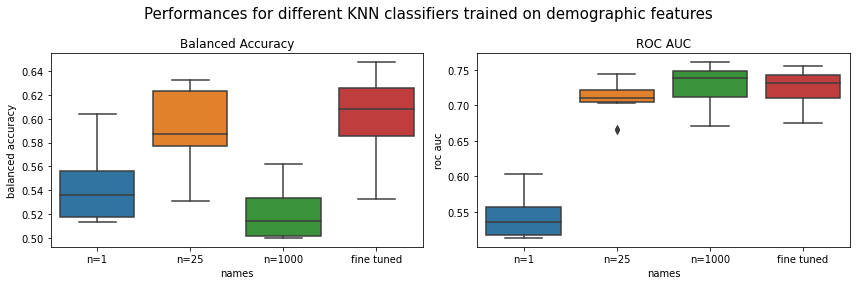

In [21]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one ###

with open('./12_knnfolds.pkl', 'rb') as fp:
    simple_folds = pickle.load(fp)
    
with open('./13_finedtunedfolds.pkl', 'rb') as fp:
    finetuned_folds = pickle.load(fp)
    
# Create visual df
knn1 = ['n=1' for x in range(len(simple_folds['balacc_1']))]
knn25 = ['n=25' for x in range(len(simple_folds['balacc_25']))]
knn1000 = ['n=1000' for x in range(len(simple_folds['balacc_1000']))]
knnft = ['fine tuned' for x in range(len(finetuned_folds['balacc']))]

names = knn1 + knn25 + knn1000 + knnft
values = simple_folds['balacc_1'] + simple_folds['balacc_25'] + simple_folds['balacc_1000'] + finetuned_folds['balacc']
balacc_df = pd.DataFrame([names, values]).transpose()
balacc_df.columns = ['names', 'values']

values = simple_folds['rocauc_1'] + simple_folds['rocauc_25'] + simple_folds['rocauc_1000'] + finetuned_folds['rocauc']
rocauc_df = pd.DataFrame([names, values]).transpose()
rocauc_df.columns = ['names', 'values']

# Create plots
plt.figure(figsize=(12, 4))
plt.suptitle('Performances for different KNN classifiers trained on demographic features', fontsize=15)

plt.subplot(1, 2, 1)
sns.boxplot(data=balacc_df, x='names', y='values')
plt.title('Balanced Accuracy')
plt.ylabel('balanced accuracy')

plt.subplot(1, 2, 2)
sns.boxplot(data=rocauc_df, x='names', y='values')
plt.title('ROC AUC')
plt.ylabel('roc auc')

plt.tight_layout()
plt.show()

### 1.4 Please describe, interpret, compare, and discuss the obtained results (performance metric scores) of the different classifiers.
### ============  YOUR WRITTEN ANSWER HERE ============== 
<span>
    
    At a first glance, it seems like changing the number of neighbours generates a more significant difference for the balanced accuracy than for the AUC scores. With n=[25, 1000, fine tuned], all average AUC scores are within the first/third quartile of the others. The kNN classifiers with n=[1000, fine tuned] exhibited a higher average AUC score and a higher maximum score than the kNN classifier with n=25, though they also suffer from a larger variance. On the other side, in terms of balanced accuracy, it seems like there is a more significant difference between n=[1, 1000] and n=[25, fined tuned], as the means of n=1 and n=1000 are well outside the first quartile of the balanced accuracies of n=25 and the fine tuned knn. Specifically, the latter kNN classifiers (n=[25, fine tuned]) exhibited higher average balance accuracy scores. It can be also observed that, with n=fine tuned, the average balance accuracy score across folds is higher (and the variance in balance accuracy scores across folds is slightly lower) than the one achieved by the kNN classifier with 25 neighbors.   
        
    When the amount of neighbours equal to 1, the classifiers performs badly, no matter the metric used. This makes sense, as we can easily overfit, and no nuance is given to the class predicted (it's either 0 or 1). The latter also explains why the ROC AUC of the knn with n=1 is very low, while the others are at around 75 no matter the balanced accuracy score.
    
    Speaking of, there seems to be a discrepancy between the balanced accuracy and the ROC AUC. This can be explained by the large imbalance in the dataset. Only 26% of the instances are from the minority class, which means that when a minority instance is predicted, it will statistically be surrounded by a certain amount of majority class instances when the number of neighbours is high. However, the prediction probabilities may be a bit lower than for majority instances, which means that were we to move the threshold from 0.5 for a lower value to predict our minority class, our algorithm may perform well, which is reflected in the roc AUC.
    
    All in all, it seems like 1 is too small to make meaningful predictions (overfitting and no nuance), while 1000 is way too many to detect our minority instances. This is reflected by the balanced accuracy, where both classifiers perform, on average, worse than the other two. 25 seems like it performs well, but the variance in performances is quite large for its balanced accuracy. However, on average, it performs the best on the balanced accuracy, and has a really high ROC AUC too. 
    
    Finetuning our algorithm, we notice that the optimal n belongs to [40, 299], with a high frequency of 199 being the optimal k. We then achieve results close to, or higher than the knn with n=25. None of them are very robust (their variance in balanced accuracy is rather large), but they both achieve high scores on the ROC AUC, with the fine tuned algorithm outperforming slightly the 25nn, and that with a small variance.

</span>

<a id="section2"></a>
## 2  Experiment with KNN classifiers and demographic plus behavioral features 
----

In this section, you should:

1. Prepare a feature matrix with only `behavioral features` for each customer (one row per customer, same behavioral features included in the phone_usage.csv, charges.csv, and/or services.csv files and that you created in the previous homework) and compute a `pair-wise distance matrix` across customers, by appropriately selecting (combining) one (or more if necessary) appropriate distance measure(s).  

2. Implement a kNN classifier with hyperparameter finetuning (i.e. finetune k over an appropriate range) and feed it with the created pairwise-distance matrix (the one that refers to only behavioral features). Evaluate the kNN classifier by using a `10-fold user-stratified cross-validation` and use `Balanced Accuracy` and `AUC` as performance metrics.
  
3. Create a pair-wise distance matrix by appropriately combining the pair-wise distance matrices you computed for only demographic features in Task 1.1 and only behavioral features in Task 2.1. Then, again prepare a finetuned kNN classifier and feed it with the combined distance matrix to predict churn. You are asked to again evaluate it using a `10-fold user-stratified cross-validation` and `Balanced Accuracy` and `AUC` as performance metrics.  

4. Report visually `Balanced Accuracy` and `AUC` of (i) the fine-tuned kNN classifier obtained in Task 1.3 (demographic, fine-tuned), (ii) the fine-tuned kNN classifier obtained in Task 2.2 (behavioral, fine-tuned), and (iii) the fine-tuned kNN classifier obtained in Task 2.3 (demographic+behavioral, fine-tuned) in such a way that they can be easily and appropriately compared. 

<a id="section2.1"></a>
### Task 2.1

As you might be observed, demographic features do not reveal how customers actually used the services, and adding behavioral features derived from the services the customers subscribed to, the extent to which they are charged monthly, and the actual phone usage, can help in improving the performance of our classifier. Therefore, in this task, we ask you to:
- Compute a feature matrix `XB` with one row per customer and one column per **behavioral** feature (i.e., **the behavioral features that you created in homework 3**). The cell `XB[i,j]` represents the value of the behavioral feature `j` for customer `i`. The shape of the matrix `XB` should be (n_customers, n_behavioral_features). 
- Compute a pair-wise distance matrix `DB` with one row per customer and one column per customer. The cell `DB[i,j]` represents the pair-wise distance between the features vectors `XB[i]` and `XB[j]` of customer `i` and customer `j`, respectively. The shape of the matrix `DB` should be (n_customers, n_customers). Please make sure to choose an appropriate distance measure. 

One important point to be addressed here is that, depending on the different nature (e.g., numerical, categorical) of the behavioral features you created in the previous homework and you are expected to use here, selecting a single distance measure to create your pair-wise distance matrix might not be the right way to move forward. If the types of your behavioral features are very different, a more advanced strategy is needed. Specifically, you might need to use different distance measures for different subsets of your behavioral features. 
To support you with this, we provide a concrete example not related to this task for illustration. In this example, we assume that we have five features for a user: height (f1), abdomen circumference (f2), favorite three movies (f3,f4, and f5). Given these features, it is appropriate to use Euclidean distance for the vector [f1,f2] and use Jaccard distance for [f3,f4,f5]. To manage this situation, given a pair `(i, j)` of users, the following strategy can be used:
- Compute the Euclidean distance for feature vectors [f1,f2] of users i and j - we assume to denote that by `t1[i,j]`. 
- Compute the Jaccard distance for [f3,f4,f5] of users i and j - we assume to denote that by `t2[i,j]`. 
- Compute the final distance as `DB[i,j] = t1[i,j] + t2[i,j]` (do not forget to check the scaling of t1 and t2). 

In [29]:
# Reproducing features from hw 3
avg_charge = charges.groupby('ContractID').mean().rename(
                   columns={'Charge': 'AvgCharge'}).reset_index()

avg_phone_usage = phone_usage.groupby('ContractID').mean().rename(
                   columns={'MonthlyUsage': 'AvgUsage'}).reset_index()

extreme_charge = (charges.groupby('ContractID').max().Charge - \
                  charges.groupby('ContractID').mean().Charge)\
.reset_index().rename(columns={'Charge': 'ExtremeCharge'})

mapping_charging_length = lambda x: 'Less than one year' if x < 12 \
                  else ('Between one and three years' \
                  if x >= 12 and x <= 36 else 'More than three years')

charging_length = charges.groupby('ContractID').size()\
.apply(mapping_charging_length).to_frame().rename(
                   columns={0: 'ChargingLength'}).reset_index()
                
nb_service = services[~services.ServiceValue.str.contains('No')]\
.groupby('ContractID').size().to_frame().rename(
             columns={0: 'NbServices'}).reset_index()

In [30]:
# Create XB

## Merging all features in one dataframe
assert len(avg_charge) == len(avg_charge['ContractID'].unique())
print('Amount of contracts: {}'.format(len(avg_charge)))

XB_df = pd.DataFrame(churn['CustomerID'])
XB_df = XB_df.merge(contract[['CustomerID', 'ContractID']], on='CustomerID', how='left')
XB_df = XB_df.merge(avg_charge[['ContractID', 'AvgCharge']], on='ContractID', how='left')
XB_df = XB_df.merge(extreme_charge[['ContractID', 'ExtremeCharge']], on='ContractID', how='left')
XB_df = XB_df.merge(avg_phone_usage[['ContractID', 'AvgUsage']], on='ContractID', how='left')
XB_df = XB_df.merge(nb_service[['ContractID', 'NbServices']], on='ContractID', how='left')
XB_df = XB_df.merge(charging_length[['ContractID', 'ChargingLength']], on='ContractID', how='left')

Amount of contracts: 6866


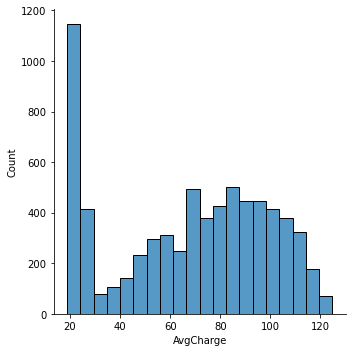

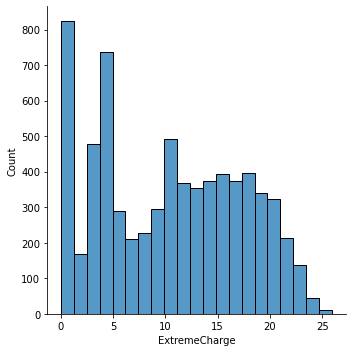

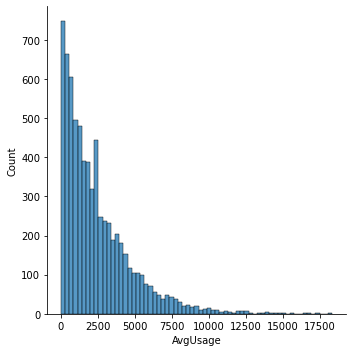

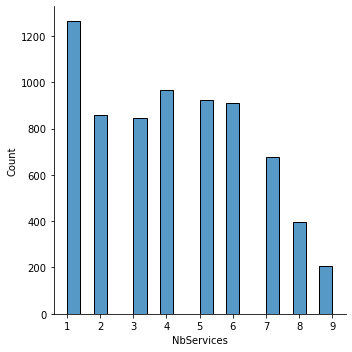

In [32]:
## Normalise the non categorical values such that the euclidean distance does not eat up the hamming distance
### Look into the data distribution for each feature
for column in ['AvgCharge', 'ExtremeCharge', 'AvgUsage', 'NbServices']:
    sns.displot((XB_df[column]))
    plt.show()


In [33]:
### Most distributions are heavy tailed, but do not contain bog outliers
for column in ['AvgCharge', 'ExtremeCharge', 'NbServices', 'AvgUsage']:
    maxi = XB_df[column].max()
    mini = XB_df[column].min()
    XB_df[column] = (XB_df[column] - mini) / (maxi - mini)

In [34]:
XB = np.array(XB_df[['AvgCharge', 'ExtremeCharge', 'AvgUsage', 'NbServices', 'ChargingLength']])

In [35]:
def matching(x, y, categorical_indices):
    '''
    1 - Sum of the characters in common, normalised by the length of the vector
    '''
    # hamming
    hamming = (sum(x[categorical_indices] == y[categorical_indices]) / len(x[categorical_indices]))
    hamming = 1 - hamming

    # euclidean
    mask = np.ones(len(x)).astype(bool)
    mask[categorical_indices] = False
    euclidean = np.linalg.norm(x[mask]-y[mask])
    
    return ((hamming * len(categorical_indices)) / len(x)) + ((euclidean * (len(x) - len(categorical_indices))) / len(x))

## Initialise the distance matrix
DB = pairwise_distances(XD, metric=lambda x, y: matching(x, y, [4]))
    

In [36]:
with open('./XB_matrix.pkl', 'wb') as fp:
    pickle.dump(XB, fp)
    
with open('./DB_matrix.pkl', 'wb') as fp:
    pickle.dump(DB, fp)

### 2.1 Please, describe, motivate, and discuss all your design choices.

### ============  YOUR WRITTEN ANSWER HERE ============== 

<span> 
    
    For this question, we decided to take the same features we used in homework 3. Out of our 5 features, one is categorical: charging_length. We thus first turn the different possible categories into numerical ones for efficiency and simplicity, and then compute the hamming distance for that feature. This metric is particularly fitted to our problem, because of the non binary nature of our features, and the lack of meaning behind the labels chosen for the categories
    
    For the ordinal, numerical, other variables, we normalise the values between 0 and 1, such that all features have the same weight when computing our distance. In order to do so, we use a min max scaling strategy, after checking that our data does not contain outliers, which may compress the range of values too much and make us lose information. In order to then compute the distance measures for our continuous features, we choose the euclidean distances, as instances with similar features will be close in the euclidean space.
    
    We compute the final distance as being the euclidean distance * (4/5) + hamming distance * (1/5). We indeed normalise the distances by the amount of variables that were included to compute those distances. Using variable names rather than magic numbers will allow us to keep this function were we to decide to change our features, or add some more.
</span>
    

<a id="section2.2"></a>
### Task 2.2

In this task, we ask you to implement a fine-tuned kNN classifier, using the pair-wise distance matrix `DB` derived from behavioral features, as an input. You can re-use and appropriately adjust the implementation you provided in task 1.3 to perform the same task but on the pair-wise distance matrix derived from demographic features. We ask you to use the again a `10-fold user-stratified cross-validation` and to compute `Balanced Accuracy` and `AUC` for this setting. No plotting is needed, it is enough to print the scores in the cell.

In [37]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
fold = 0
folds = {
    'y_test' : [],
    'test_index': [],
    'ypred': [],
    'yprobs': [],
    'rocauc': [],
    'balacc': [],
    'best_params': [],
}

with open('./DB_matrix.pkl', 'rb') as fp:
    DB = pickle.load(fp)
    
for train_index, test_index in skf.split(DB, y):
    # Separate train and test
    x_train = np.array([DB[t_i][train_index] for t_i in train_index])
    x_test = np.array([DB[t_i][train_index] for t_i in test_index])
    
    y_train = np.array(y[train_index])
    y_test = np.array(y[test_index])
    
    # Gridsearch
    ## Setup
    neighbours = [5] + list(range(11, 50, 2)) + list(range(59, 100, 10)) + [159] + list(range(199, 900, 100))
    parameters = {
        'n_neighbors': neighbours
    }
    knn = KNeighborsClassifier(metric='precomputed')
    clf = GridSearchCV(knn, parameters, cv=10, scoring='balanced_accuracy')
    
    ## Classification
    clf.fit(x_train, y_train)
    ypred = clf.predict(x_test)
    yprobs = clf.predict_proba(x_test)
    
    balacc = balanced_accuracy_score(y_test, ypred)
    auc = roc_auc_score(y_test, yprobs[:, 1])
    
    ## Save data
    folds['y_test'] = folds['y_test'] + list(y_test)
    folds['test_index'] = folds['test_index'] + list(test_index)
    folds['ypred'] = folds['ypred'] + list(ypred)
    folds['yprobs'] = folds['yprobs'] + list(yprobs)
    folds['rocauc'].append(auc)
    folds['balacc'].append(balacc)
    folds['best_params'].append(clf.best_params_)
    fold += 1


In [38]:
with open('./22_knnfolds.pkl', 'wb') as fp:
    pickle.dump(folds, fp)

#### Alternative solution

In [39]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###
with open('./DB_matrix.pkl', 'rb') as fp:
    DB = pickle.load(fp)
    
neighbours = [5] + list(range(11, 50, 2)) + list(range(59, 100, 10)) + [159] + list(range(199, 900, 100))
parameters = {
    'n_neighbors': neighbours
}
knn = KNeighborsClassifier(metric='precomputed')
clf = GridSearchCV(knn, parameters, cv=10, scoring='balanced_accuracy')
gridsearchcv_results = cross_validate(clf, DB, y, cv=10, scoring=['roc_auc', 'balanced_accuracy'])

In [40]:
print('Overall performances for classifier for different k values: \n{} +/- {} (bacc), {} +/- {} (auc)'.format(
                                        np.mean(gridsearchcv_results['test_balanced_accuracy']), 
                                        np.std(gridsearchcv_results['test_balanced_accuracy']), 
                                        np.mean(gridsearchcv_results['test_roc_auc']), 
                                        np.std(gridsearchcv_results['test_roc_auc'])))


Overall performances for classifier for different k values: 
0.6081972036098161 +/- 0.025464366264920338 (bacc), 0.7221812677242211 +/- 0.019418528507808785 (auc)


<a id="section2.3"></a>
### Task 2.3

Once you reach this point, you have considered demographic features and behavioral features, separately. In this task, we ask you to use the pair-wise distance matrices `DD` and `DB`, obtained for only demographic features and only behavioral features respectively, to appropriately create a single pair-wise distance matrix `D` that considers both demographic and behavioral features jointly. To obtain this pair-wise distance matrix `D`, compute `D[i,j] = DD[i,j] + DB[i,j]`, for each `(i,j)` pair and do not forget to take into account the scaling of DD and DB.

Finally, we ask you to implement a fine-tuned kNN classifier, using the pair-wise distance matrix `D` as an input. You can again re-use and appropriately adjust the implementation you provided in Tasks 1.3 and 2.2 to perform the same task but on the pair-wise distance matrix `D` derived from both demographic and behavioral features. Again, you should use a `10-fold user-stratified cross-validation` and compute `Balanced Accuracy` and `AUC` for this setting. It is fine to just print the results in the cell.

<span>
    
    Note that here, it is not necessary to normalise DD and DB by the amount of features the distances were computed for.
    
<span>

In [41]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###

# Read data
with open('./DD_matrix.pkl', 'rb') as fp:
    DD = pickle.load(fp)
    
with open('./DB_matrix.pkl', 'rb') as fp:
    DB = pickle.load(fp)
    
n_demographic = 6
n_behavioural = 5


D = (DD / n_demographic) + (DB / n_behavioural)


In [42]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
fold = 0
folds = {
    'y_test' : [],
    'test_index': [],
    'ypred': [],
    'yprobs': [],
    'rocauc': [],
    'balacc': [],
    'best_params': [],
}

for train_index, test_index in skf.split(D, y):
    # Separate train and test
    x_train = np.array([D[t_i][train_index] for t_i in train_index])
    x_test = np.array([D[t_i][train_index] for t_i in test_index])
    
    y_train = np.array(y[train_index])
    y_test = np.array(y[test_index])
    
    # Gridsearch
    ## Setup
    neighbours = [5] + list(range(11, 50, 2)) + list(range(59, 100, 10)) + [159] + list(range(199, 900, 100))
    parameters = {
        'n_neighbors': neighbours
    }
    knn = KNeighborsClassifier(metric='precomputed')
    clf = GridSearchCV(knn, parameters, cv=10, scoring='balanced_accuracy')
    
    ## Classification
    clf.fit(x_train, y_train)
    ypred = clf.predict(x_test)
    yprobs = clf.predict_proba(x_test)
    
    balacc = balanced_accuracy_score(y_test, ypred)
    auc = roc_auc_score(y_test, yprobs[:, 1])
    
    ## Save data
    folds['y_test'] = folds['y_test'] + list(y_test)
    folds['test_index'] = folds['test_index'] + list(test_index)
    folds['ypred'] = folds['ypred'] + list(ypred)
    folds['yprobs'] = folds['yprobs'] + list(yprobs)
    folds['rocauc'].append(auc)
    folds['balacc'].append(balacc)
    folds['best_params'].append(clf.best_params_)
    fold += 1


In [43]:
print('Scores: {} +/- {} (auc), {} +/- {} (bal accuracy)'.format(np.mean(folds['rocauc']), 
                                                                np.std(folds['rocauc']),
                                                                np.mean(folds['balacc']),
                                                                np.std(folds['balacc'])
                                                                )
     )

print('Per fold, the best parameters were: ')
for i in range(10):
    print('     {}'.format(folds['best_params'][i]))

Scores: 0.7264868640586639 +/- 0.017519409832034524 (auc), 0.6093207581802196 +/- 0.021647684362605897 (bal accuracy)
Per fold, the best parameters were: 
     {'n_neighbors': 199}
     {'n_neighbors': 159}
     {'n_neighbors': 17}
     {'n_neighbors': 199}
     {'n_neighbors': 199}
     {'n_neighbors': 199}
     {'n_neighbors': 199}
     {'n_neighbors': 89}
     {'n_neighbors': 299}
     {'n_neighbors': 89}


In [44]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###
    
neighbours = [5] + list(range(11, 50, 2)) + list(range(59, 100, 10)) + [159] + list(range(199, 900, 100))
parameters = {
    'n_neighbors': neighbours
}
knn = KNeighborsClassifier(metric='precomputed')
clf = GridSearchCV(knn, parameters, cv=10, scoring='balanced_accuracy')
gridsearchcv_results = cross_validate(clf, D, y, cv=10, scoring=['roc_auc', 'balanced_accuracy'])

<a id="section2.2"></a>
### Task 2.4

Once you reach this point, you should have:
1. The fine-tuned kNN classifier obtained in Task 1.3 (demographic, fine-tuned).
2. The fine-tuned kNN classifier obtained in Task 2.2 (behavioral, fine-tuned).
3. The fine-tuned kNN classifier obtained in Task 2.3 (demographic+behavioral, fine-tuned).  

In this last task, we ask you to visually report the performance of the three above kNN classifiers. Basically, you should again properly visualize the `Balanced Accuracy` and `AUC` scores achieved by the mentioned classifiers in the 10-fold user-stratified cross validation performed in the respective tasks (Task 1.3, Task 2.2, and Task 2.3), so that the classifiers can be easily compared. 

In [45]:
with open('./23_knnfolds.pkl', 'wb') as fp:
    pickle.dump(folds, fp)

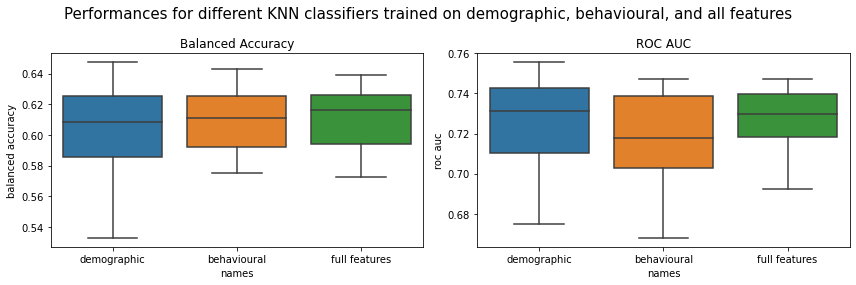

In [46]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one ###
with open('./13_finedtunedfolds.pkl', 'rb') as fp:
    demographic_folds = pickle.load(fp)
    
with open('./22_knnfolds.pkl', 'rb') as fp:
    behavioural_folds = pickle.load(fp)

with open('./23_knnfolds.pkl', 'rb') as fp:
    full_folds = pickle.load(fp)
    
# Create visual df
dem_names = ['demographic' for x in range(len(demographic_folds['balacc']))]
beh_names = ['behavioural' for x in range(len(behavioural_folds['balacc']))]
full_names = ['full features' for x in range(len(full_folds['balacc']))]

names = dem_names + beh_names + full_names
values = demographic_folds['balacc'] + behavioural_folds['balacc'] + full_folds['balacc']
balacc_df = pd.DataFrame([names, values]).transpose()
balacc_df.columns = ['names', 'values']

values = demographic_folds['rocauc'] + behavioural_folds['rocauc'] + full_folds['rocauc']
rocauc_df = pd.DataFrame([names, values]).transpose()
rocauc_df.columns = ['names', 'values']

# Create plots
plt.figure(figsize=(12, 4))
plt.suptitle('Performances for different KNN classifiers trained on demographic, behavioural, and all features', fontsize=15)

plt.subplot(1, 2, 1)
sns.boxplot(data=balacc_df, x='names', y='values')
plt.title('Balanced Accuracy')
plt.ylabel('balanced accuracy')

plt.subplot(1, 2, 2)
sns.boxplot(data=rocauc_df, x='names', y='values')
plt.title('ROC AUC')
plt.ylabel('roc auc')

plt.tight_layout()
plt.show()

In [47]:
print('Scores for the behavioural features: {} +/- {} (bal acc), {} +/- {} (auc)'.format(
    np.mean(behavioural_folds['balacc']), np.std(behavioural_folds['balacc']),
    np.mean(behavioural_folds['rocauc']), np.std(behavioural_folds['rocauc'])
))

Scores for the behavioural features: 0.6087729406424146 +/- 0.021020237205863684 (bal acc), 0.7162211218299933 +/- 0.025130975645771637 (auc)


### 2.4 Please describe, interpret, compare, and discuss the obtained results (performance metric scores) of the different classifiers.

### ============  YOUR WRITTEN ANSWER HERE ============== 

<span>
    
    From the left plot above, it can be observed that the kNN classifier trained on demographic features only (blue box) exhibited a lower average balanced accuracy and a higher variance of balanced accuracy across folds with respect to the kNN classifier trained on behavioral features only (orange box), indicating that the predictive power instilled by behavioral features to kNN is higher and more stable across folds than the one instilled by demographic features to kNN, when balanced accuracy is considered. This is also confirmed by the minimum and maximum balanced accuracy scores achieved in the two settings, especially when we observe that the minimum score achieved by the kNN with demographic features is four percentage-points lower than the minimum score obtained by the kNN with behavioral features. Once we combine the two set of features (green box), the corresponding kNN classifier performs better on average and shows a lower variance in scores than the kNN classifiers trained on behavioural or demographic features separately in terms of balanced accuracy, though the first and third quartile of all three combinations largely overlap with each other across classifiers (especially between behavioral features only and full features). kNNs with behavioral features only and with the full features perform similarly in terms of minimum and maximum scores. 
    
    Compared to our first above observations, the above right plot highlights that the kNN classifier trained on demographic features only (blue box) performs better, on average, with respect to the kNN classifier trained on behavioral features only (orange box) in terms of AUC scores. They show a similar variance. Minimu and maximum AUC scores are slightly lower for the kNN classifier with behavioral features only. Finally, the kNN classifier trained on the combination of features (green box) and the kNN classifier trained on demographic features (blue box) have a very similar average AUC score across folds, and the average AUC score achieved by the kNN classifier trained on both feature sets is higher than the average AUC score achieved by the kNN classifier trained on behavioral features only. While the average AUC score between classifiers using demographic features only and both feature sets is really similar, again, it should be noted that the latter exhibited a lower variance across folds and a higher minimum score, indicating that it might be more robust to fold variance.
    
    We observed that for all sets of features, the predictive power is not that high. Several components can explain this phenomena: 
    - There are so few minority instances than adding some features gets too confusing (curse of dimensionality), and does not help the algorithm (full).
    - The way of aggregating distances does not work. Euclidean distances may be lower than the hamming distances. We may be giving too much weight to one feature type than the other (full).
    - The way of normalising our values erases to much details (full-demographic-behavioural)
    - This classification task is genuinely hard, no matter the set of features used (full-demographic-behavioural)
</span>

## Congratulations

Congratulations! Please, carefully revise your solution and push it when you feel that it is ok. 
